In [1]:
import copy
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from tqdm import tqdm

from common import ( 
    hwc_to_chw, chw_to_hwc, crop, Tiler, unproject, export_point_cloud, estimate_normals, draw_roi
)
from networks import create_network
from data import SLSDataset
from persistence import Checkpoint

device = torch.device('cuda:0')

def disable_ticks(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

def load_network(path, device):
    checkpoint = Checkpoint.load(path, map_location=device)

    config = {}
    checkpoint.restore_config(config)

    num_channels = 1

    if 'color_dir_name' in config['input']['train']:
        num_channels += 3

    if 'ambient_dir_name' in config['input']['train']:
        num_channels += 3

    network = create_network(num_channels, 1, config=config['network'])
    network = network.to(device)
    checkpoint.restore_model(network)

    return network, checkpoint, config

def plot_sample(sample, figsize=(30, 15), **kwargs):
    depth_groundtruth = sample['target']
    mask_groundtruth = depth_groundtruth > 0

    depth_reconstructed = sample['depth']
    mask_reconstructed = depth_reconstructed > 0

    mask = mask_groundtruth & mask_reconstructed

    min_depth = depth_groundtruth[mask].min()
    max_depth = depth_groundtruth[mask].max()

    fig, axs = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)
    axs[0].set_title('Mask')
    axs[0].imshow(mask)
    axs[1].set_title('Ground Truth')
    im = axs[1].imshow(depth_groundtruth, vmin=min_depth, vmax=max_depth, cmap='viridis')
    axs[2].set_title('Reconstructed')
    axs[2].imshow(depth_reconstructed, vmin=min_depth, vmax=max_depth, cmap='viridis')
    cbar = fig.colorbar(im, ax=axs[2], shrink=0.445)
    cbar.ax.set_ylabel('Meters')
    plt.show()

def predict(network, sample, device, tiler=None):
    input = torch.tensor(sample['depth'])

    if 'color' in sample:
        input = torch.cat([input, torch.tensor(sample['color'])], dim=-1)

    if 'ambient' in sample:
        input = torch.cat([input, torch.tensor(sample['ambient'])], dim=-1)

    if not tiler:
        #tiler = Tiler(256, overlap=0.75, margin=0) 
        # Tiler used for the qualitative experiment (rook, pawn, ..)
        tiler = Tiler(256, overlap=0.94, margin=100) 
        #tiler = Tiler(256, overlap=0.875, margin=64)

    tiles = tiler.split(input)

    with torch.no_grad():
        for chunk in tqdm(torch.split(tiles, 16)):
            chunk[...] = chw_to_hwc(network(hwc_to_chw(chunk).to(device)).cpu())

    depth_predicted = tiler.join(sample['depth'].shape, tiles)
    depth_predicted[sample['depth'] == 0] = 0

    return depth_predicted

## Figure XXX (small-scale error in the data)

In [2]:
import cv2

data_config = {
    'base_dir' : "G:/data/sls/v2001a/train",
    #'base_dir' : "G:/data/sls/v1705/train",
    'color_dir_name': '.',
    'color_file_pattern': '*_cam_w*',
    'ambient_dir_name': '.',
    'ambient_file_pattern': '*_cam_a*',
    'transform': None
}
dataset = SLSDataset(**data_config, preload=False)

#sample_indices = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55 ]
#sample_indices = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45 ]
#sample_indices = [0, 5, 15, 20, 25, 35, 40 ] # 36
#sample_indices = [0, 5, 25, 35, 40 ] # 26
#sample_indices = [0, 5, 35, 40 ] # 21.7, 9
#sample_indices = [ 5, 40 ]
sample_indices = [ 40 ]
#sample_indices = [ 22 ] # v1705

samples = []

for sample_index in sample_indices:
    samples += [ dataset[sample_index] ]

# Add the rook to the samples
name = "rook"
sample = {}
sample['target'] = np.load(f"data/old/{name}/dm_gt.npy")[:, :, np.newaxis]
sample['color'] = plt.imread(f"data/old/{name}/{name}_match_white.png")
sample['depth'] = np.load(f"data/old/{name}/dm_scan.npy")[:, :, np.newaxis]
#sample['target'] = np.load(f"data/{name}/dm_gt.npy")[:, :, np.newaxis]
#sample['color'] = plt.imread(f"data/{name}/{name}_match_white.png")
#sample['depth'] = np.load(f"data/{name}/dm_scan.npy")[:, :, np.newaxis]

# # Stuff for new dataset
# sample['target'] = sample['target'][:, 1:-1]
# sample['color'] = cv2.resize(sample['color'], dsize=(sample['target'].shape[:2][::-1]))
# sample['depth'] = cv2.resize(sample['depth'], dsize=(sample['target'].shape[:2][::-1]))[:, :, np.newaxis]
# sample['depth'] /= 1000.0

# Make it square (v2001)
xcrop = (sample['color'].shape[1] - sample['color'].shape[0]) // 2
sample['color'] = sample['color'][:, xcrop:-xcrop]
xcrop = (sample['depth'].shape[1] - sample['depth'].shape[0]) // 2
sample['depth'] = sample['depth'][:, xcrop:-xcrop]
xcrop = (sample['target'].shape[1] - sample['target'].shape[0]) // 2
sample['target'] = sample['target'][:, xcrop:-xcrop]
samples += [sample]

NameError: name 'SLSDataset' is not defined

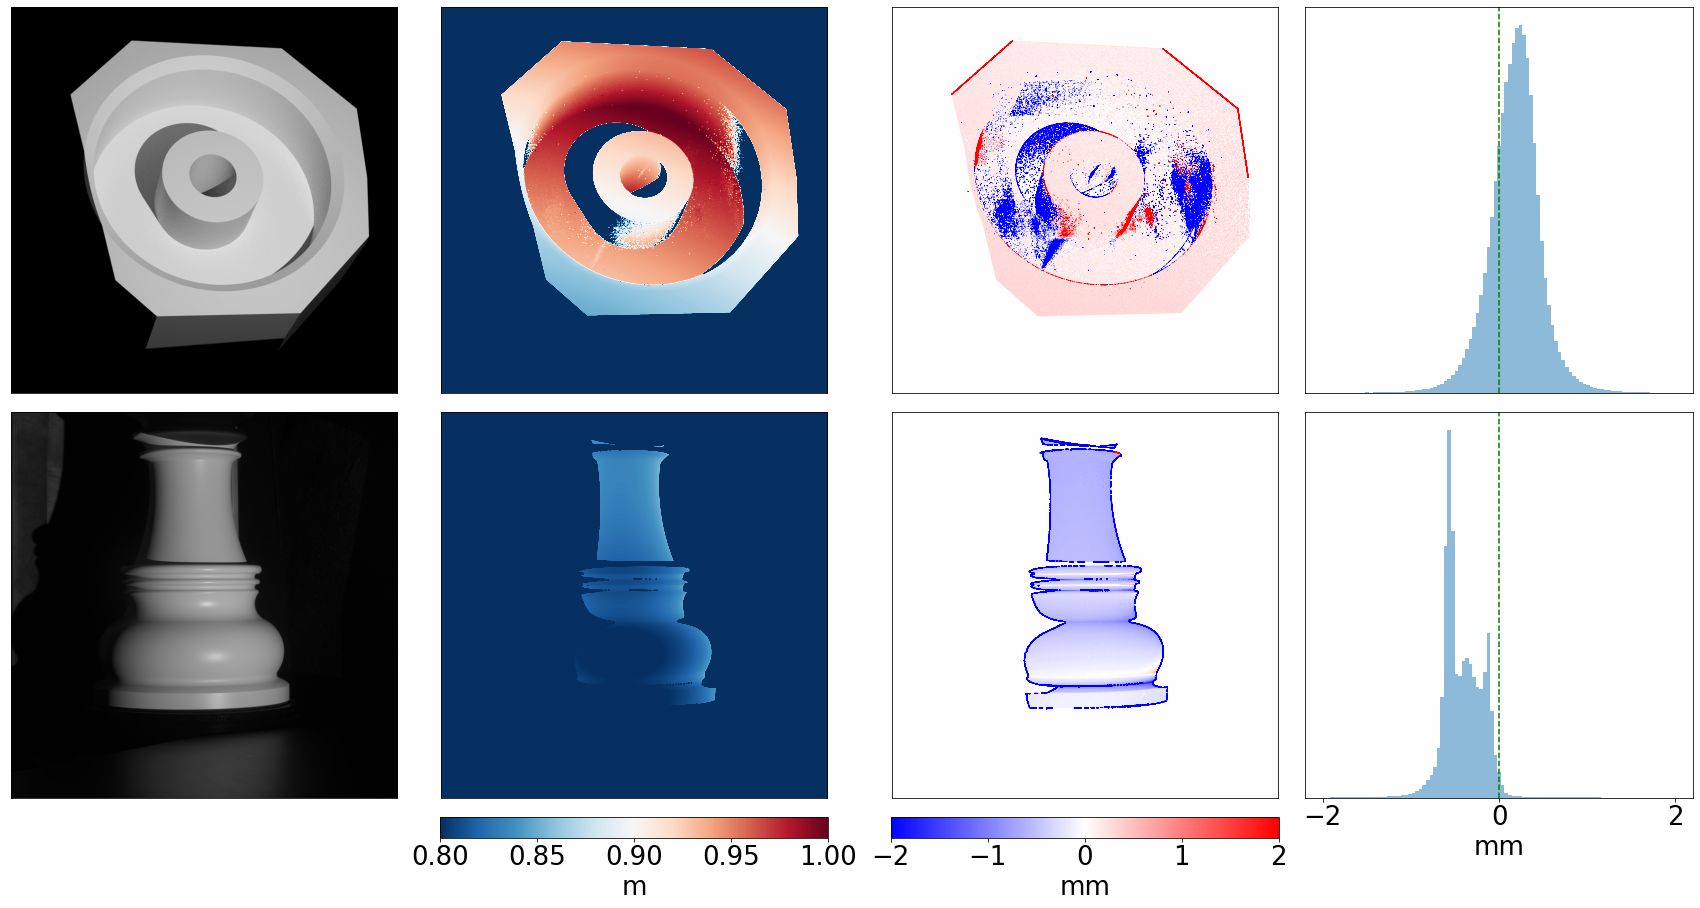

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

scale = (1000.0, "mm")
fontsize = 26

num_cols = 4
num_rows = len(samples)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(23.5, num_rows * 5.75 + 1), constrained_layout=True) #v2001
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(23, num_rows * 4 + 1), constrained_layout=True) #v1705

if num_rows == 1:
    axs = [axs]

depth_min = 0.8
depth_max = 1.0
#depth_min = 0.65
#depth_max = 1.15

error_threshold = 0.002 * scale[0]
#error_threshold = 0.0015 * scale[0]
error_min = -error_threshold
error_max = error_threshold

for i, sample in enumerate(samples):
    depth_groundtruth = copy.deepcopy(sample['target'])
    mask_groundtruth = depth_groundtruth > 0
    depth_reconstructed = copy.deepcopy(sample['depth'])
    mask_reconstructed = depth_reconstructed > 0

    error_reconstructed = (depth_reconstructed - depth_groundtruth) * scale[0]
    error_reconstructed[~mask_reconstructed] = 0

    axs[i][0].get_xaxis().set_ticks([])
    axs[i][0].get_yaxis().set_ticks([])
    axs[i][0].imshow(sample['color'])

    axs[i][1].get_xaxis().set_ticks([])
    axs[i][1].get_yaxis().set_ticks([])
    # Ground truth goes towards 0 at the borders, so we cannot use its minimum for a reasonable value range
    im = axs[i][1].imshow(depth_reconstructed, cmap='RdBu_r', vmin=depth_min, vmax=depth_max)
    if i == len(samples) - 1:
        #cbaxes = inset_axes(axs[i][1], width="90%", height="5%", loc=3) 
        #cbar = fig.colorbar(im, cax=cbaxes, orientation='horizontal')#, aspect=10, pad=0.025)
        cbar = fig.colorbar(im, ax=axs[i][1], aspect=10, pad=0.025,  location='bottom')
        cbar.ax.set_xlabel('m', fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)

    # if i == 0:
    #     axs[i][0].set_title("Color Image", fontsize=fontsize)
    #     axs[i][1].set_title("Depth", fontsize=fontsize)
    #     axs[i][2].set_title("Depth Error", fontsize=fontsize)
    #     axs[i][3].set_title("Error Distribution", fontsize=fontsize)

    axs[i][2].get_xaxis().set_ticks([])
    axs[i][2].get_yaxis().set_ticks([])
    im = axs[i][2].imshow(error_reconstructed, vmin=error_min, vmax=error_max, cmap='bwr')

    if i == len(samples) - 1:
        cbar = fig.colorbar(im, ax=axs[i][2], aspect=10, pad=0.025, location="bottom")
        cbar.ax.set_xlabel(scale[1], fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)
        labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

    bins = np.linspace(-error_threshold, error_threshold, 100)
    axs[i][3].hist(error_reconstructed[mask_reconstructed & (np.abs(error_reconstructed) < error_threshold)].ravel(), bins=bins, alpha=0.5)
    if i == len(samples) - 1:
        axs[i][3].set_xlabel(scale[1], fontsize=fontsize)
    else:
        axs[i][3].get_xaxis().set_ticks([])
    axs[i][3].axvline(x=0, color='green', linestyle='--')
    axs[i][3].tick_params(labelsize=fontsize)
    axs[i][3].get_yaxis().set_ticks([])

plt.savefig("reconstruction_errors.png", facecolor='white')
plt.show()

## Figure XXX (denoising virtual test objects; comparison between scan, ml and baselines)

In [2]:
# Load the model
#network_a, checkpoint, config = load_network(R"G:\Source\CG\sls_sim\experiments\denoising\out\version_0\checkpoints\last.ckpt", device=device)
#network_b, checkpoint, config = load_network(R"G:\Source\CG\sls_sim\experiments\denoising\out\version_2\checkpoints\last.ckpt", device=device)
#network_a, checkpoint, config = load_network(R"G:\Source\CG\sls_sim\experiments\denoising\out\version_6\checkpoints\20000.ckpt", device=device)
network_a, checkpoint, config = load_network(R"G:\Source\CG\sls_sim\experiments\denoising\out\version_7\checkpoints\550.ckpt", device=device)
network_b = network_a

initialize network with normal


In [6]:
#sample_indices = [0, 1, 2, 3, 4 ] # Testset indices v2001a
#sample_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ] # Testset indices v2001b
#sample_indices = range(11, 22)                       # 
#sample_indices = range(22, 25)                       # 
#sample_indices = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 ] # Trainset indices
#sample_indices = [3, 6, 8, 18, 19] # v2001b testset paper indices

from baselines import bilateral_depth_filter, laplace_depth_filter

# Calibration
K =  [[6.4660295107919637e+03, 0., 1.0232077305518850e+03], 
      [0., 6.4659159387660493e+03, 1.0229550801975000e+03], 
      [0., 0., 1. ]]
R = np.eye(3)
t = np.zeros(3)

tiler = None # Tiler(256, overlap=0.75, margin=0)
# samples = []

# # ABC v2001a:
# dataset_config = copy.deepcopy(config['input']['test'])
# dataset_config.update({
#     #'base_dir': "G:/data/sls/v2001a/test",
#     'base_dir': "G:/data/sls/v1705/test",
#     'preload': False,
#     'transform': None,
#     'repetitions': 1,
# })
# sample = SLSDataset(**dataset_config)[0]
# sample['depth_ml'] = predict(network_a, sample, device, tiler=tiler)
# sample['depth_bilateral'] = bilateral_depth_filter(sample['depth'], 2.2583333333333333, 0.005)
# sample['depth_laplace'] = laplace_depth_filter(sample['depth'], K, R, t)
# samples += [ sample ]

# #sample = SLSDataset(**dataset_config)[1]
# sample = SLSDataset(**dataset_config)[3]
# sample['depth_ml'] = predict(network_a, sample, device, tiler=tiler)
# sample['depth_bilateral'] = bilateral_depth_filter(sample['depth'], 2.2583333333333333, 0.005)
# sample['depth_laplace'] = laplace_depth_filter(sample['depth'], K, R, t)
# samples += [ sample ]

# # ABC v2001b:
# dataset_config = copy.deepcopy(config['input']['test'])
# dataset_config.update({
#     #'base_dir': "G:/data/sls/v2001b/test",
#     'base_dir': "G:/data/sls/v1705/test",
#     'preload': False,
#     'transform': None,
#     'repetitions': 1,
# })
# #sample = SLSDataset(**dataset_config)[18]
# sample = SLSDataset(**dataset_config)[6]
# sample['depth_ml'] = predict(network_b, sample, device, tiler=tiler)
# sample['depth_bilateral'] = bilateral_depth_filter(sample['depth'], 2.2583333333333333, 0.005)
# sample['depth_laplace'] = laplace_depth_filter(sample['depth'], K, R, t)
# samples += [ sample ]

samples = []
for sample in SLSDataset(**dataset_config):
    sample['depth_ml'] = predict(network_b, sample, device, tiler=tiler)
    sample['depth_bilateral'] = bilateral_depth_filter(sample['depth'], 2.2583333333333333, 0.005)
    sample['depth_laplace'] = laplace_depth_filter(sample['depth'], K, R, t)
    samples += [ sample ]

100%|██████████| 2187/2187 [02:11<00:00, 16.67it/s]
Tiler: Max sample count in join operation is 16
100%|██████████| 2187/2187 [02:22<00:00, 15.33it/s]
Tiler: Max sample count in join operation is 16
100%|██████████| 2187/2187 [02:09<00:00, 16.95it/s]
Tiler: Max sample count in join operation is 16
100%|██████████| 2187/2187 [02:10<00:00, 16.73it/s]
Tiler: Max sample count in join operation is 16
100%|██████████| 2187/2187 [02:29<00:00, 14.63it/s]
Tiler: Max sample count in join operation is 16
100%|██████████| 2187/2187 [02:07<00:00, 17.09it/s]
Tiler: Max sample count in join operation is 16
100%|██████████| 2187/2187 [02:11<00:00, 16.61it/s]
Tiler: Max sample count in join operation is 16
100%|██████████| 2187/2187 [01:57<00:00, 18.57it/s]
Tiler: Max sample count in join operation is 16


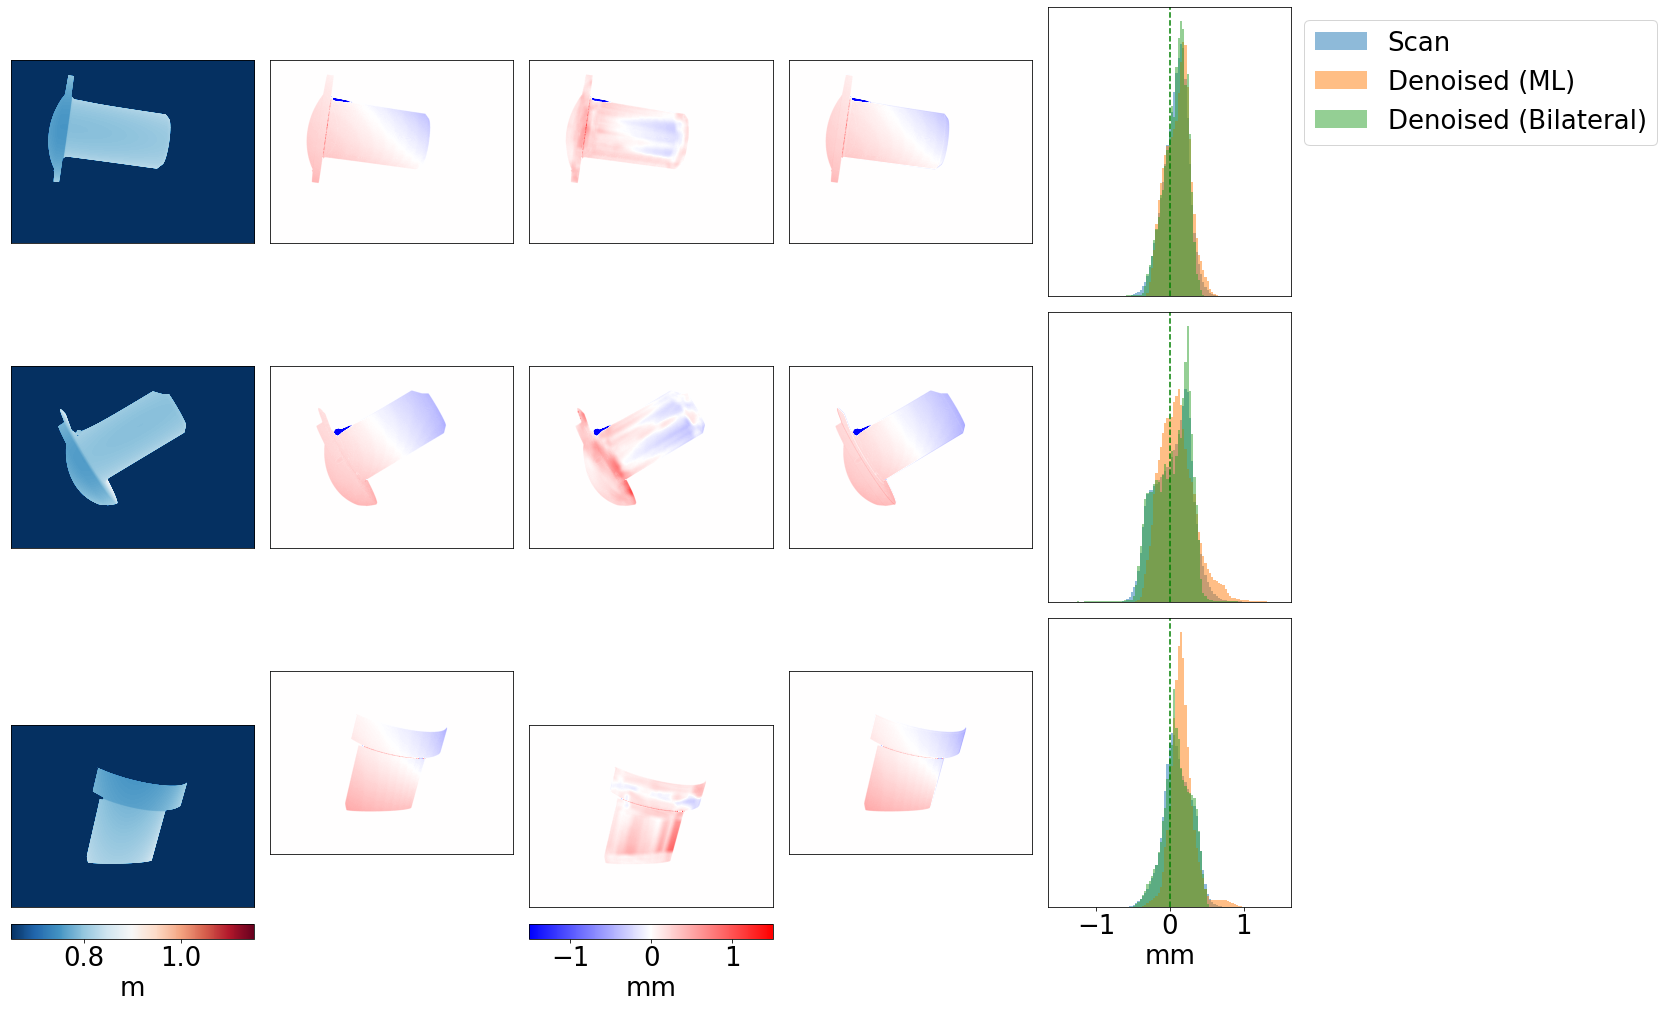

In [4]:
scale = (1000.0, "mm")
fontsize = 26

num_cols = 5
num_rows = len(samples)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(23, num_rows*4.4 + 0.7), constrained_layout=True)

if num_rows == 1:
    axs = [axs]

#depth_min = 0.8
#depth_max = 1.0
depth_min = 0.65
depth_max = 1.15

#error_threshold = 0.002 * scale[0]
error_threshold = 0.0015 * scale[0]
error_min = -error_threshold
error_max = error_threshold

for i, sample in enumerate(samples):
    depth_groundtruth = copy.deepcopy(sample['target'])
    mask_groundtruth = depth_groundtruth > 0
    depth_reconstructed = copy.deepcopy(sample['depth'])
    mask_reconstructed = depth_reconstructed > 0

    ax_idx = 0

    # Ground truth goes towards 0 at the borders, so we cannot use its minimum for a reasonable value range
    im = axs[i][ax_idx].imshow(sample['depth'], vmin=depth_min, vmax=depth_max, cmap='RdBu_r')
    disable_ticks(axs[i][ax_idx])

    if i == len(samples) - 1:
        cbar = fig.colorbar(im, ax=axs[i][ax_idx], aspect=10, pad=0.025,  location='bottom')
        cbar.ax.set_xlabel('m', fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)

    ax_idx += 1

    # Error map of the reconstruction/scan
    error_reconstructed = (depth_reconstructed - depth_groundtruth) * scale[0]
    error_reconstructed[~mask_reconstructed] = 0
    axs[i][ax_idx].imshow(error_reconstructed, vmin=error_min, vmax=error_max, cmap='bwr')
    disable_ticks(axs[i][ax_idx])

    ax_idx += 1

    # Error map of the ml denoising
    error_denoised_ml = (sample['depth_ml'].numpy() - depth_groundtruth) * scale[0]
    error_denoised_ml[~mask_reconstructed] = 0
    im = axs[i][ax_idx].imshow(error_denoised_ml, vmin=error_min, vmax=error_max, cmap='bwr')
    disable_ticks(axs[i][ax_idx])

    if i == len(samples) - 1:
        cbar = fig.colorbar(im, ax=axs[i][ax_idx], aspect=10, pad=0.025, location='bottom')
        cbar.ax.set_xlabel(scale[1], fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)

    ax_idx += 1

    # Error map of the bilateral filter denoising
    error_denoised_bilateral = (sample['depth_bilateral'] - depth_groundtruth) * scale[0]
    error_denoised_bilateral[~mask_reconstructed] = 0
    axs[i][ax_idx].imshow(error_denoised_bilateral, vmin=error_min, vmax=error_max, cmap='bwr')
    disable_ticks(axs[i][ax_idx])

    ax_idx += 1

    # # Error map of the laplace denoising
    # error_denoised_laplace = (sample['depth_laplace'] - depth_groundtruth) * scale[0]
    # error_denoised_laplace[~mask_reconstructed] = 0
    # axs[i][4].imshow(error_denoised_laplace, vmin=error_min, vmax=error_max, cmap='bwr')
    # disable_ticks(axs[i][4])

    # ax_idx += 1

    # 
    bins = np.linspace(-error_threshold, error_threshold, 100)

    axs[i][ax_idx].hist(error_reconstructed[mask_reconstructed & (np.abs(error_reconstructed) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Scan')
    axs[i][ax_idx].hist(error_denoised_ml[mask_reconstructed & (np.abs(error_denoised_ml) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (ML)')
    axs[i][ax_idx].hist(error_denoised_bilateral[mask_reconstructed & (np.abs(error_denoised_bilateral) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (Bilateral)')
    #axs[i][ax_idx].hist(error_denoised_laplace[mask_reconstructed & (np.abs(error_denoised_laplace) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (Laplace)')
    if i == len(samples) - 1:
        axs[i][ax_idx].set_xlabel(scale[1], fontsize=fontsize)
    else:
        axs[i][ax_idx].get_xaxis().set_ticks([])
    axs[i][ax_idx].axvline(x=0, color='green', linestyle='--')
    axs[i][ax_idx].tick_params(labelsize=fontsize)
    axs[i][ax_idx].get_yaxis().set_ticks([])
    if i == 0:
        axs[i][ax_idx].legend(fontsize=fontsize, loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.savefig("denoising_errors.png", facecolor='white')
plt.show()

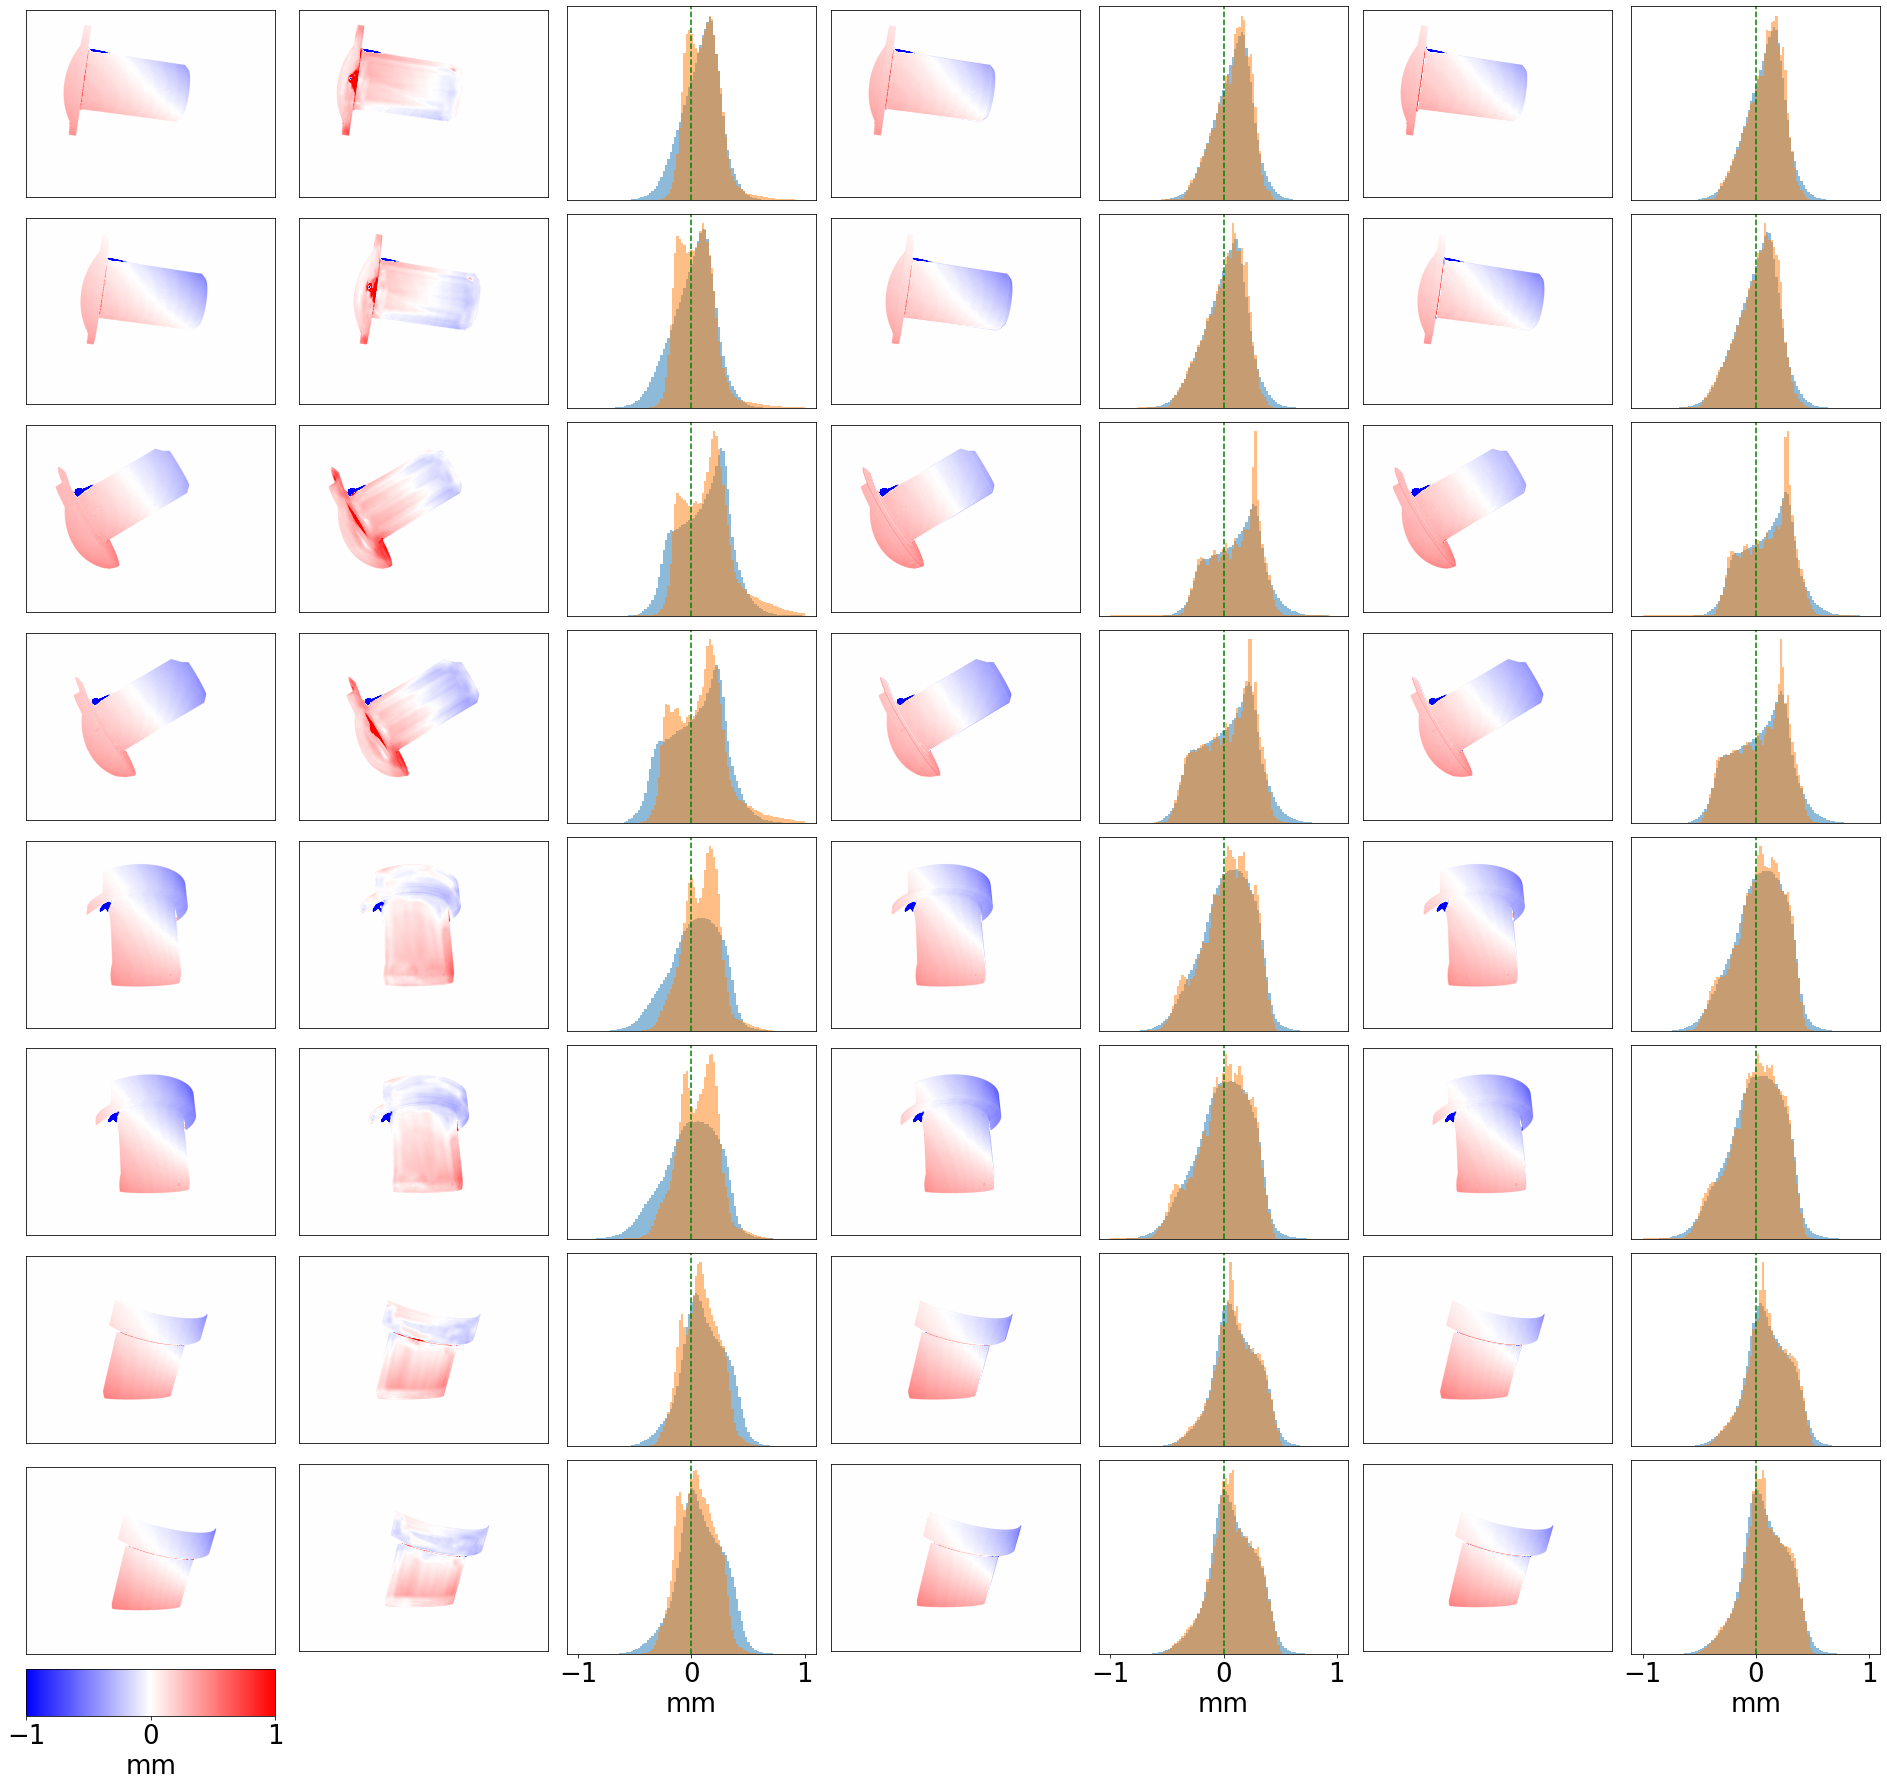

In [7]:
# V2
scale = (1000.0, "mm")
fontsize = 26

num_cols = 7
num_rows = len(samples)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(26.1, num_rows*3 + 0.7), constrained_layout=True)

if num_rows == 1:
    axs = [axs]

#depth_min = 0.8
#depth_max = 1.0
depth_min = 0.65
depth_max = 1.15

#error_threshold = 0.002 * scale[0]
error_threshold = 0.001 * scale[0]
error_min = -error_threshold
error_max = error_threshold

bins = np.linspace(-error_threshold, error_threshold, 100)

for i, sample in enumerate(samples):
    depth_groundtruth = copy.deepcopy(sample['target'])
    mask_groundtruth = depth_groundtruth > 0
    depth_reconstructed = copy.deepcopy(sample['depth'])
    mask_reconstructed = depth_reconstructed > 0

    ax_idx = 0

    # Error map of the reconstruction/scan
    error_reconstructed = (depth_reconstructed - depth_groundtruth) * scale[0]
    error_reconstructed[~mask_reconstructed] = 0
    axs[i][ax_idx].imshow(error_reconstructed, vmin=error_min, vmax=error_max, cmap='bwr')
    disable_ticks(axs[i][ax_idx])

    if i == len(samples) - 1:
        cbar = fig.colorbar(im, ax=axs[i][ax_idx], aspect=5, pad=0.025, location='bottom')
        cbar.ax.set_xlabel(scale[1], fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)

    ax_idx += 1

    # Error map of the ml denoising
    error_denoised_ml = (sample['depth_ml'].numpy() - depth_groundtruth) * scale[0]
    error_denoised_ml[~mask_reconstructed] = 0
    im = axs[i][ax_idx].imshow(error_denoised_ml, vmin=error_min, vmax=error_max, cmap='bwr')
    disable_ticks(axs[i][ax_idx])

    ax_idx += 1

    axs[i][ax_idx].axvline(x=0, color='green', linestyle='--')
    axs[i][ax_idx].hist(error_reconstructed[mask_reconstructed & (np.abs(error_reconstructed) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Scan')
    axs[i][ax_idx].hist(error_denoised_ml[mask_reconstructed & (np.abs(error_denoised_ml) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (ML)')
    if i == len(samples) - 1:
        axs[i][ax_idx].tick_params(labelsize=fontsize)
        axs[i][ax_idx].set_xlabel(scale[1], fontsize=fontsize)
    else:
        axs[i][ax_idx].get_xaxis().set_ticks([])
    axs[i][ax_idx].get_yaxis().set_ticks([])
    ax_idx += 1

    # Error map of the bilateral filter denoising
    error_denoised_bilateral = (sample['depth_bilateral'] - depth_groundtruth) * scale[0]
    error_denoised_bilateral[~mask_reconstructed] = 0
    axs[i][ax_idx].imshow(error_denoised_bilateral, vmin=error_min, vmax=error_max, cmap='bwr')
    disable_ticks(axs[i][ax_idx])

    ax_idx += 1

    axs[i][ax_idx].axvline(x=0, color='green', linestyle='--')
    axs[i][ax_idx].hist(error_reconstructed[mask_reconstructed & (np.abs(error_reconstructed) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Scan')
    axs[i][ax_idx].hist(error_denoised_bilateral[mask_reconstructed & (np.abs(error_denoised_bilateral) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (Bilateral)')
    if i == len(samples) - 1:
        axs[i][ax_idx].tick_params(labelsize=fontsize)
        axs[i][ax_idx].set_xlabel(scale[1], fontsize=fontsize)
    else:
        axs[i][ax_idx].get_xaxis().set_ticks([])
    axs[i][ax_idx].get_yaxis().set_ticks([])
    ax_idx += 1

    # Error map of the laplace denoising
    error_denoised_laplace = (sample['depth_laplace'] - depth_groundtruth) * scale[0]
    error_denoised_laplace[~mask_reconstructed] = 0
    axs[i][ax_idx].imshow(error_denoised_laplace, vmin=error_min, vmax=error_max, cmap='bwr')
    disable_ticks(axs[i][ax_idx])

    ax_idx += 1

    axs[i][ax_idx].axvline(x=0, color='green', linestyle='--')
    axs[i][ax_idx].hist(error_reconstructed[mask_reconstructed & (np.abs(error_reconstructed) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Scan')
    axs[i][ax_idx].hist(error_denoised_laplace[mask_reconstructed & (np.abs(error_denoised_laplace) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (Laplace)')
    if i == len(samples) - 1:
        axs[i][ax_idx].tick_params(labelsize=fontsize)
        axs[i][ax_idx].set_xlabel(scale[1], fontsize=fontsize)
    else:
        axs[i][ax_idx].get_xaxis().set_ticks([])
    axs[i][ax_idx].get_yaxis().set_ticks([])

    ax_idx += 1

    # # 
    # bins = np.linspace(-error_threshold, error_threshold, 100)

    # axs[i][ax_idx].hist(error_reconstructed[mask_reconstructed & (np.abs(error_reconstructed) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Scan')
    # axs[i][ax_idx].hist(error_denoised_ml[mask_reconstructed & (np.abs(error_denoised_ml) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (ML)')
    # axs[i][ax_idx].hist(error_denoised_bilateral[mask_reconstructed & (np.abs(error_denoised_bilateral) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (Bilateral)')
    # #axs[i][ax_idx].hist(error_denoised_laplace[mask_reconstructed & (np.abs(error_denoised_laplace) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised (Laplace)')
    # if i == len(samples) - 1:
    #     axs[i][ax_idx].set_xlabel(scale[1], fontsize=fontsize)
    # else:
    #     axs[i][ax_idx].get_xaxis().set_ticks([])
    # axs[i][ax_idx].axvline(x=0, color='green', linestyle='--')
    # axs[i][ax_idx].tick_params(labelsize=fontsize)
    # axs[i][ax_idx].get_yaxis().set_ticks([])
    # if i == 0:
    #     axs[i][ax_idx].legend(fontsize=fontsize, loc="upper left", bbox_to_anchor=(1.0, 1.0))

plt.savefig("denoising_errors_v2.png", facecolor='white')
plt.show()

## Figure XXX (denoising rook; results on depth map) 

In [6]:
name = "rook"

#gt = np.load(f"data/old/{name}/dm_gt.npy")[:, :, np.newaxis]
#sim = np.load(f"data/old/{name}/dm_sim.npy")[:, :, np.newaxis]
#scan = np.load(f"data/old/{name}/dm_scan.npy")[:, :, np.newaxis]
gt = np.load(f"data/{name}/dm_gt.npy")[:, :, np.newaxis]
sim = np.load(f"data/{name}/dm_sim.npy")[:, :, np.newaxis]
scan = np.load(f"data/{name}/dm_scan.npy")[:, :, np.newaxis]

if name == "pawn":
    scan[sim == 0] = 0

# Stuff for the new dataset...
gt = gt[:, 1:-1]
sim = cv2.resize(sim, dsize=(gt.shape[:2][::-1]))[:, :, np.newaxis]
sim /= 1000.0
scan = cv2.resize(scan, dsize=(gt.shape[:2][::-1]))[:, :, np.newaxis]
scan /= 1000.0

In [7]:
# Prefer v2001b for rook
# Version7; 250 was ok. 420 was also ok
#network, checkpoint, config = load_network(R"G:\Source\CG\sls_sim\experiments\denoising\out\version_2\checkpoints\last.ckpt", device=device)
#network, checkpoint, config = load_network(R"G:\Source\CG\sls_sim\experiments\denoising\out\version_6\checkpoints\11000.ckpt", device=device)
network, checkpoint, config = load_network(R"G:\Source\CG\sls_sim\experiments\denoising\out\version_6\checkpoints\20000.ckpt", device=device)
#network, checkpoint, config = load_network(R"G:\Source\CG\sls_sim\experiments\denoising\out\version_7\checkpoints\550.ckpt", device=device)
denoised = predict(network, {'depth': scan}, device)

initialize network with normal
100%|██████████| 2187/2187 [01:47<00:00, 20.43it/s]
Tiler: Max sample count in join operation is 16


<ipython-input-8-01432a1f810d>:17: RuntimeWarning: divide by zero encountered in true_divide
  error_ratio = np.abs(error_denoised) / np.abs(error_reconstructed)
<ipython-input-8-01432a1f810d>:17: RuntimeWarning: invalid value encountered in true_divide
  error_ratio = np.abs(error_denoised) / np.abs(error_reconstructed)


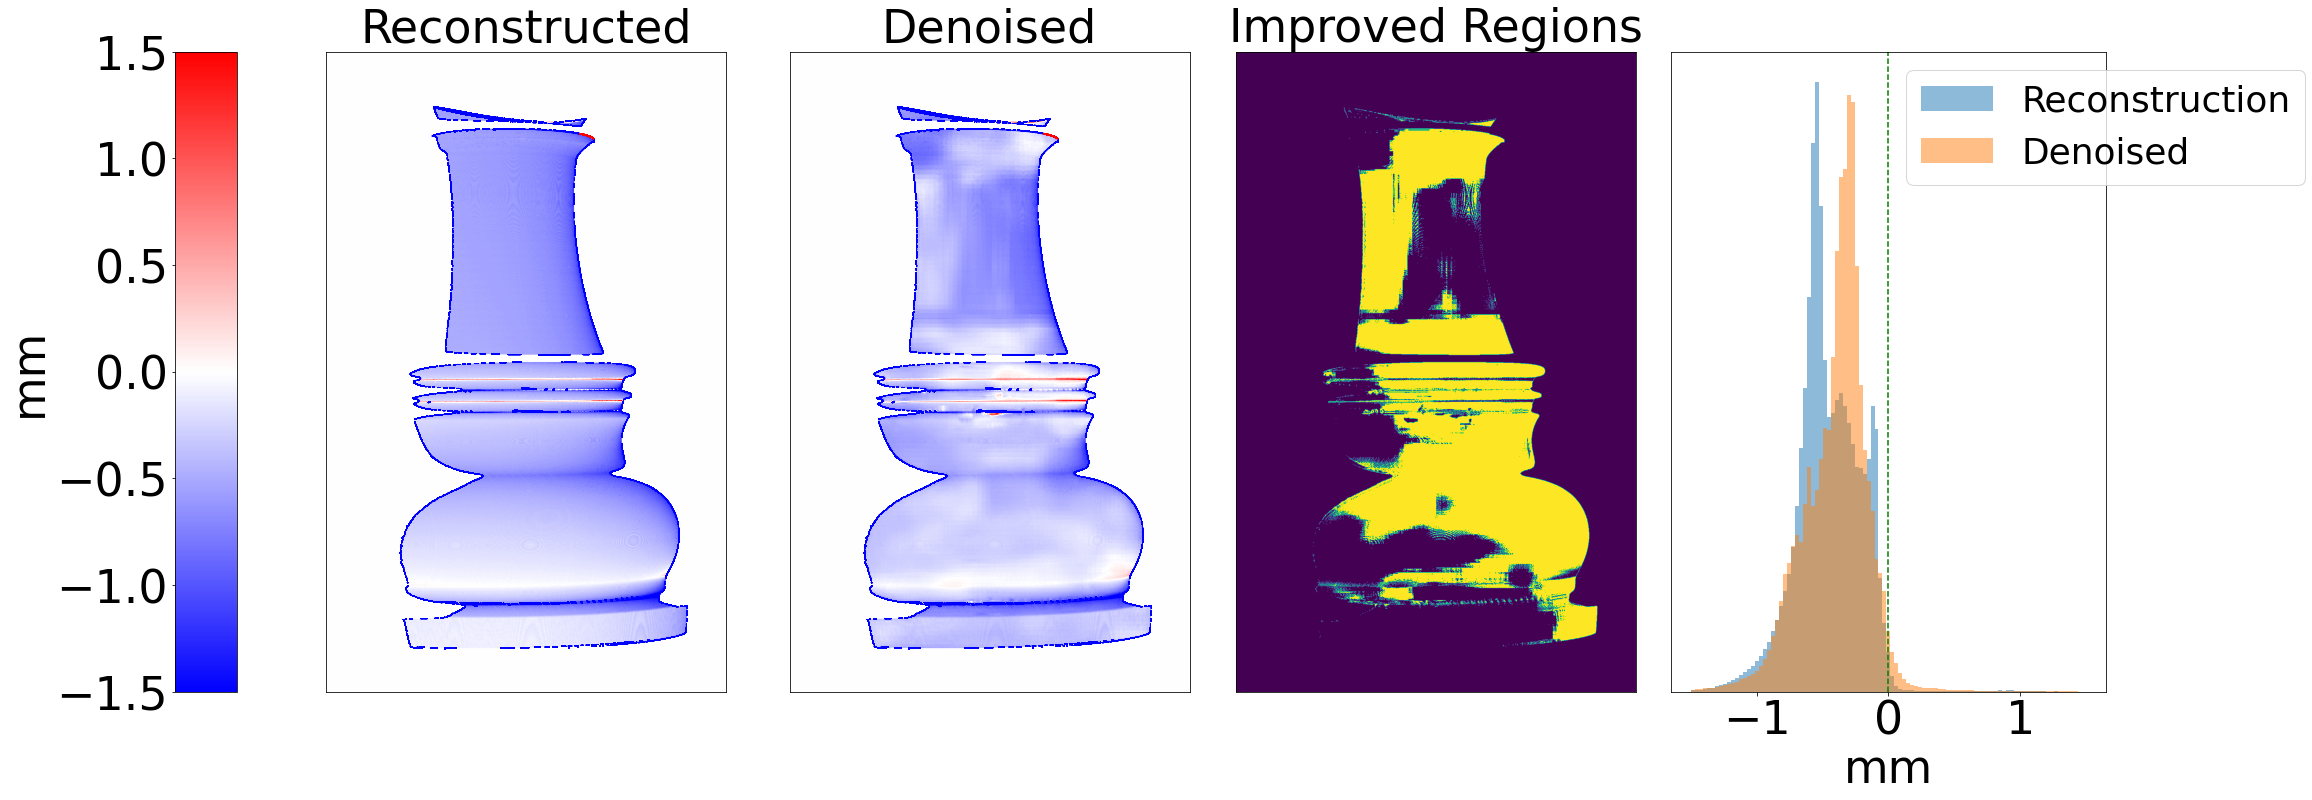

In [8]:
scale = (1000.0, "mm")
fontsize = 46
roi = [0, 2000, 1000, 2250]

error_threshold = 0.0015 * scale[0]
error_min = -error_threshold
error_max = error_threshold

mask_reconstructed = scan > 0

error_reconstructed = (scan - gt) * scale[0]
error_reconstructed[~mask_reconstructed] = 0

error_denoised = (denoised.numpy() - gt) * scale[0]
error_denoised[~mask_reconstructed] = 0

error_ratio = np.abs(error_denoised) / np.abs(error_reconstructed)
error_ratio[error_reconstructed == 0] = 0

fig, axs = plt.subplots(1, 4, figsize=(32, 11), constrained_layout=True)

axs[0].set_title("Reconstructed", fontsize=fontsize)
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
im = axs[0].imshow(crop(error_reconstructed, roi), vmin=error_min, vmax=error_max, cmap='bwr')

cbar = fig.colorbar(im, ax=[axs[0]], location='left', aspect=30, pad=0.04)
cbar.ax.set_ylabel(scale[1], fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

#axs[1].axis('off')
axs[1].set_title("Denoised", fontsize=fontsize)
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
im = axs[1].imshow(crop(error_denoised, roi), vmin=error_min, vmax=error_max, cmap='bwr')

axs[2].set_title("Improved Regions", fontsize=fontsize)
axs[2].get_xaxis().set_ticks([])
axs[2].get_yaxis().set_ticks([])
im = axs[2].imshow(crop(np.abs(error_denoised) < np.abs(error_reconstructed), roi), cmap='viridis')

bins = np.linspace(-error_threshold, error_threshold, 100)
axs[3].hist(error_reconstructed[mask_reconstructed & (np.abs(error_reconstructed) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Reconstruction')
axs[3].hist(error_denoised[mask_reconstructed & (np.abs(error_denoised) < error_threshold)].ravel(), bins=bins, alpha=0.5, label='Denoised')
axs[3].set_xlabel(scale[1], fontsize=fontsize)
axs[3].axvline(x=0, color='green', linestyle='--')
axs[3].tick_params(labelsize=fontsize)
axs[3].get_yaxis().set_ticks([])
axs[3].legend(fontsize=fontsize-10, loc='upper left', bbox_to_anchor=(0.5, 1.0))

plt.savefig("denoising_error_rook.png", facecolor='white')
plt.show()

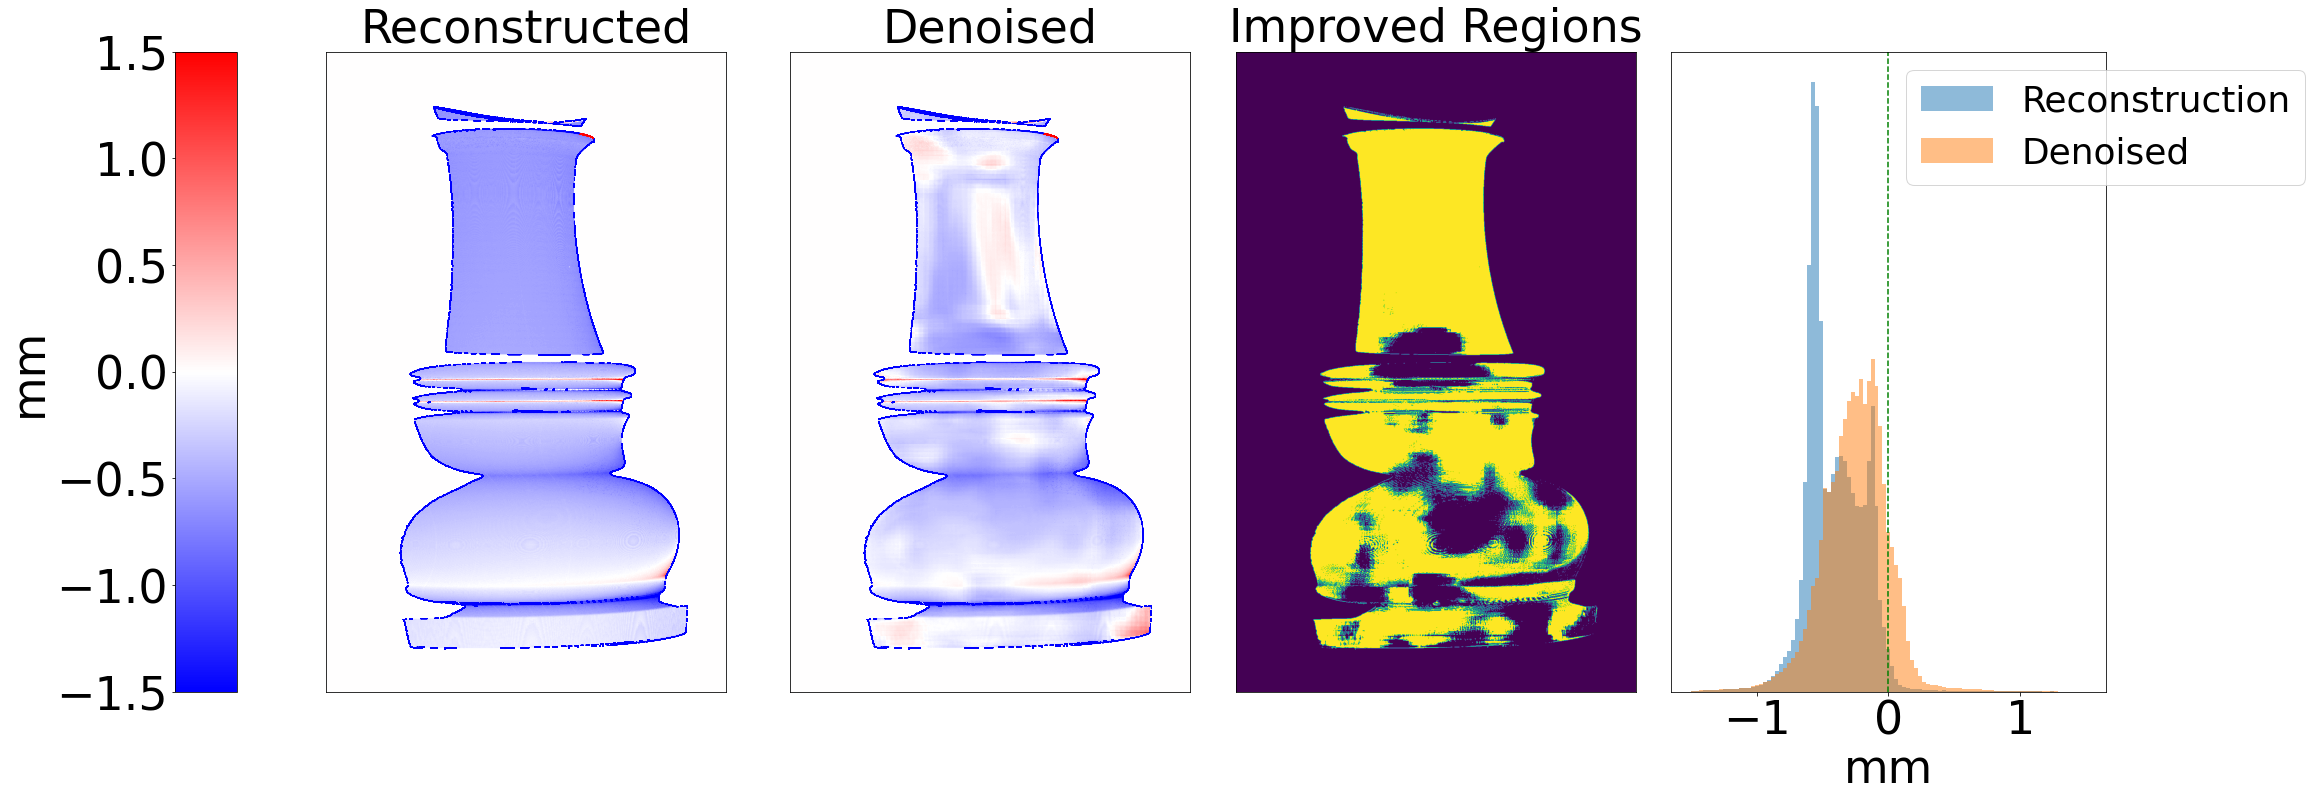

In [59]:
# This is for v2001a!

## Figure XXX (denoising rook; results on point cloud)

In [14]:
def render_pointcloud(input_path, output_path):
    import subprocess
    cmd = ["python", str(Path(".") / ".." / "poisson" / "render.py")]
    cmd += [str(input_path), str(output_path)]
    cmd += ["--geometry_type", "pointcloud"]
    cmd += ["--scale", "1"]
    cmd += ["--point_radius", "0.0003"]
    cmd += ["--eye", "-0.01", "-0.04", "0.6", "--fov", "45", "--target", "0", "0", "1"]
    cmd += ["--light_pos", "0.07", "-0.03", "0.85", "--light_color", " 1.7"]
    cmd += ["--accumulation_steps", "256"]
    cmd += ["--no_plane"]
    print(" ".join(cmd))
    try:
        return subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        raise RuntimeError("command '{}' return with error (code {}): {}".format(e.cmd, e.returncode, e.output))

In [15]:
K =  [[6.4660295107919637e+03, 0., 1.0232077305518850e+03], 
      [0., 6.4659159387660493e+03, 1.0229550801975000e+03], 
      [0., 0., 1. ]]

# # MTX
# K = 0.5 * np.array([[ 14870.341916206251, 0.0, 3231.0911004310733 ],
#                    [ 0.0, 14881.773449227723, 2423.170911321493 ],
#                    [ 0.0, 0.0, 1.0 ]])

# # New MTX
K = 0.5 * np.array([[ 14700.7978515625, 0.0, 3230.5765901904233],
                   [ 0.0, 14711.431640625, 2422.6457405752153],
                   [ 0.0, 0.0, 1.0]])
K[2, 2] = 1.0

R = np.eye(3)
t = np.zeros(3)

# Export and render the point clouds
output_dir = Path("temp/figrook")
output_dir.mkdir(parents=True, exist_ok=True)
export_point_cloud(str(output_dir / "gt.ply"), gt, K, R, t)
export_point_cloud(str(output_dir / "scan.ply"), scan, K, R, t)
export_point_cloud(str(output_dir / "denoised.ply"), denoised.numpy(), K, R, t)

render_pointcloud(output_dir / "gt.ply", output_dir / "gt.png")
render_pointcloud(output_dir / "scan.ply", output_dir / "scan.png")
render_pointcloud(output_dir / "denoised.ply", output_dir / "denoised.png")

python ..\poisson\render.py temp\figrook\gt.ply temp\figrook\gt.png --geometry_type pointcloud --scale 1 --point_radius 0.0003 --eye -0.01 -0.04 0.6 --fov 45 --target 0 0 1 --light_pos 0.07 -0.03 0.85 --light_color  1.7 --accumulation_steps 256 --no_plane


RuntimeError: command '['python', '..\\poisson\\render.py', 'temp\\figrook\\gt.ply', 'temp\\figrook\\gt.png', '--geometry_type', 'pointcloud', '--scale', '1', '--point_radius', '0.0003', '--eye', '-0.01', '-0.04', '0.6', '--fov', '45', '--target', '0', '0', '1', '--light_pos', '0.07', '-0.03', '0.85', '--light_color', ' 1.7', '--accumulation_steps', '256', '--no_plane']' return with error (code 9009): b'Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.\r\n'

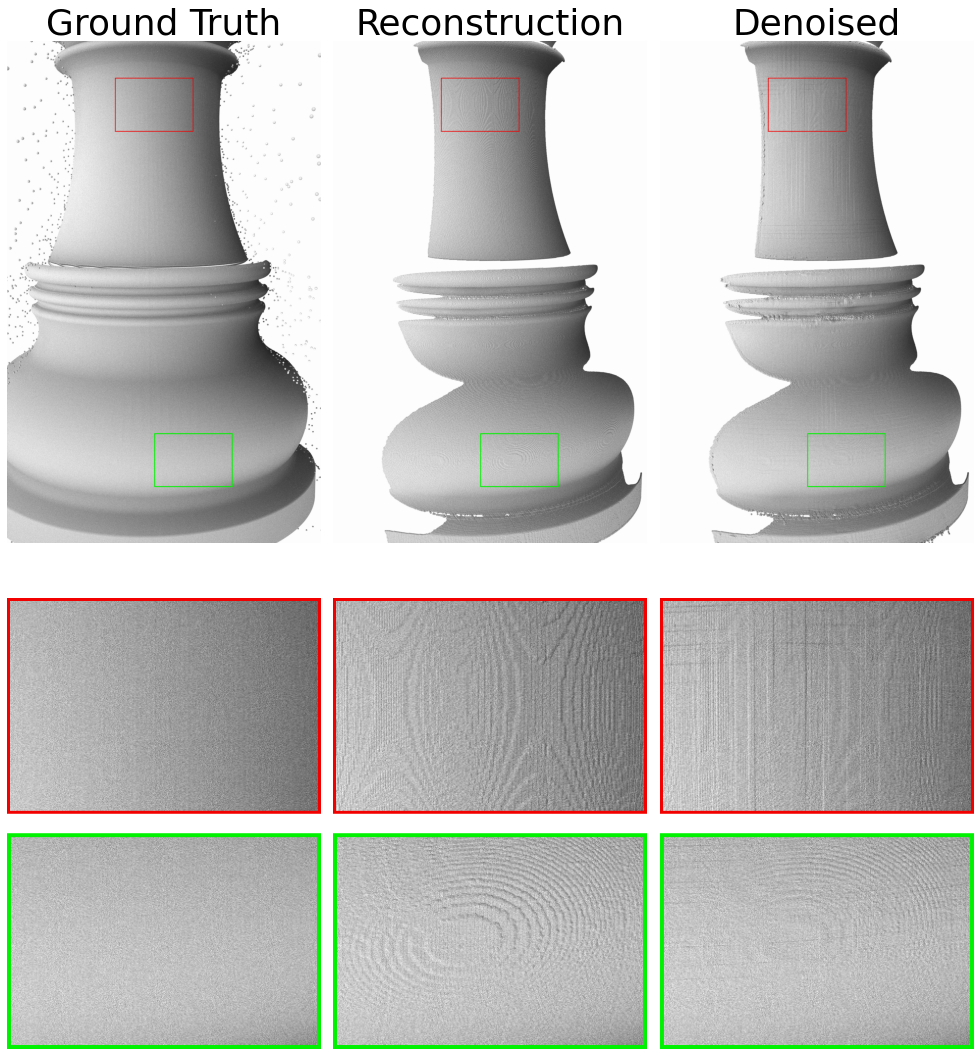

In [16]:
inches_per_column = 4.5
fontsize = 36

height = 15
fig, axs = plt.subplots(2, 3, figsize=(3*inches_per_column, height), constrained_layout=True)

for ax in axs.flatten():
    ax.axis("off")

roi_width = 320
roi1 = [150, 150 + 220, 440, 440 + roi_width]
roi2 = [1600, 1600 + 220, 600, 600 + roi_width]

for i, (path, title) in enumerate([(output_dir / "gt.png", "Ground Truth"), (output_dir / "scan.png", "Reconstruction"), (output_dir / "denoised.png", "Denoised")]):
    image = plt.imread(path)
    image_with_roi =  draw_roi(image, roi1, thinkness=3, color=[0.95, 0, 0])
    image_with_roi =  draw_roi(image_with_roi, roi2, thinkness=4, color=[0, 0.95, 0])
    axs[0][i].set_title(title, fontsize=fontsize)
    axs[0][i].imshow(image_with_roi)

    axs[1][i].imshow(np.concatenate([crop(image_with_roi, roi1), np.ones((20, roi_width, image_with_roi.shape[2])), crop(image_with_roi, roi2)], axis=0))

plt.savefig("denoising_pointclouds.png")
plt.show()